In [18]:
import os
import pandas as pd
import numpy as np
import kaggle
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [19]:
# Set the path for the dataset folder
folder = 'dataset'
os.makedirs(folder, exist_ok=True)

In [20]:
# Download the dataset using Kaggle API
kaggle.api.dataset_download_files('mlg-ulb/creditcardfraud', path=folder, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [21]:
# Load the dataset
data = pd.read_csv(os.path.join(folder, 'creditcard.csv'))

# Display the first few rows of the dataset
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [22]:
# Check for Missing Values
if data.isnull().sum().sum() == 0:
    print("No missing values in the dataset.")
else:
    print("Dataset contains missing values.")


No missing values in the dataset.


In [23]:
# Feature Scaling for 'Amount' and 'Time'
scaler = StandardScaler()
data['scaled_amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Amount', 'Time'], axis=1)

In [24]:
# Print the first few rows of the processed dataset
print(data.head())



         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  scaled_amount  scaled_time  

In [25]:
# Splitting Data into Features and Target Variable
X = data.drop('Class', axis=1)
y = data['Class']

In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [27]:
# Logistic Regression Model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)


In [28]:
# Random Forest Model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [29]:
# Evaluation Metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Evaluate Logistic Regression Model
evaluate_model(y_test, y_pred_lr, "Logistic Regression")

# Evaluate Random Forest Model
evaluate_model(y_test, y_pred_rf, "Random Forest")



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
[[85280    15]
 [   57    91]]

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.76      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
[[85289     6]
 [   36   112]]


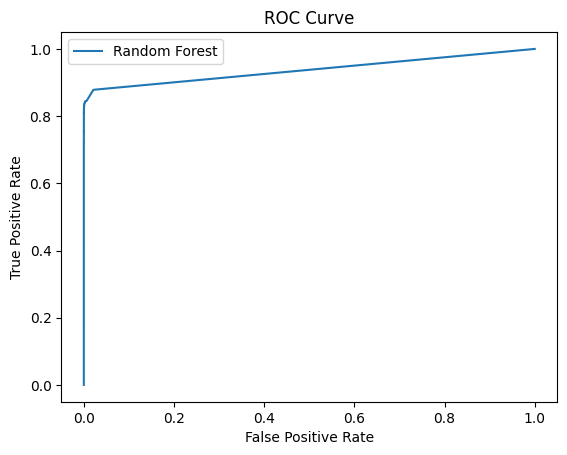

In [30]:
# ROC Curve for Random Forest
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [31]:
# Save the Model
import joblib
joblib.dump(model_rf, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']